# Parameter Scanning in OCELOT

This Jupyter notebook shows how you can easily and efficiently scan parameters in OCELOT, compile the results and get a nice plot at the end showing the impact of variation in the parameter on the bunch at arbitrary points in hte machine.  In this example we vary the bunch length, but it could be anything at all (dipole angle, bunch charge, physics process parameter, or a combination of these).  The parameter scans can be run in parallel run either locally (using the built-in `multiprocessing` module) or with MPI (using `mpi4py`, not covered here).

Let's imagine that you want to simulate the effect of CSR on a bunch in a chicane, but you want to do it for a few different bunch lengths and see the relationship between the initial bunch length and the final transverse horizontal projected emittance.  This example shows you how to do it, and then you should be able to adapt it for you own use case.

In [47]:
from math import radians, cos

import h5py
import matplotlib.pyplot as plt

from ocelot import *
from ocelot.cpbd.track import ParameterScanner
from ocelot.cpbd.io import h5py_group_to_parray

Before reading this explanation and implementation read on past the `BunchLengthScanner` implementation and see first how it is used.

A parameter scan is defined by inheriting `ocelot.cpbd.track.ParameterScanner`, overriding the `prepare_navigator` method, instantiating the derived class, and then calling the `scan` method on that instance.  The `prepare_navigator` method is called internally when calling `scan` before every tracking run, and takes the `parameter`, the initial `parray` that will be used for that run and the `job_index`, which is a unique integer defining that specific run.  The `Navigator` defines almost everything about your OCELOT simulation (except the initial particle distribution), so this is why scans are implemented in terms of modification to some common `Navigator` instance.  The only thing that cannot be varied here is the ParticleArray instance to be used.  It is only provided as an argument in case the Navigator must be modified based on some property of the beam, as is the case here–different bunch lengths require different `CSR.sigma_min` values. 

In [9]:
class BunchLengthScanner(ParameterScanner):
    def prepare_navigator(self, length, parray, job_index):
        # Start by calling the parent's method to get the base Navigator instance we wish to adapt.
        navi = super().prepare_navigator(length, parray, job_index)
        # Define CSR instance and attach to the navigator
        sigma_min = 0.1 * length # could also get from parray.tau().std()
        c = CSR()
        c.n_bin = 300
        c.m_bin = 5
        c.sigma_min = sigma_min
        start = navi.lat.sequence[0]
        end = navi.lat.sequence[-1]
        navi.add_physics_proc(c, start, end)
        # Always return this new navigator.
        return navi


In [66]:
# We start by defining our latice.  It is a chicane.
dstart = Drift(eid="driftstart", l=0.1)
b1 = SBend(l=0.5, angle=-angle, e1=0, e2=-angle)
b2 = SBend(l=0.5, angle=angle, e1=angle, e2=0.0)
b3 = SBend(l=0.5, angle=angle, e1=0.0, e2=angle)
b4 = SBend(l=0.5, angle=-angle, e1=-angle, e2=0.0)
di = Drift(l=1)
d0 = Drift(l=5 / cos(angle))
df = Drift(l=2)
cell = [dstart, b1, d0, b2, di, b3, marker, d0, b4, df]


# Standard OCELOT boilerplate
magnetic_lattice = MagneticLattice(cell, method={"global": SecondTM})
navi = Navigator(magnetic_lattice)
navi.unit_step = 0.1

# Define beam parameters and list of parrays, one for each
# of the bunch lengths we're interested in scanning.  
# We just do three here for brevity.
charge = 250e-12 # 250pC
interesting_bunch_lengths = [1e-6, 10e-6, 20e-6]
parray0s = [generate_parray(charge=charge, sigma_tau=tau) for tau in interesting_bunch_lengths]
# Finally we instantiate our scanner.  
# `navi` is the Navigator instance to use as a base for each simulation
# and may be modified within BunchLengthScanner as necessary using the `prepare_navigator` method (see below)
# to provide arbitrary simulation-by-simulation 
# The string "bunch length" is simply written to the output file as metadata
# to tell the file reader what the scan was of, so it can be anything here.
# We provide the kwarg markers to 
# tell the scanner to write the distribution to file at this point 
# (in addition to the end which is always written).
bunch_length_scanner = BunchLengthScanner(navi, # The Navigator to use
                                          interesting_bunch_lengths, # the 3 bunch lengths
                                          parray0s, # The 3 parray0s to simulate
                                          "bunch length", # Parameter name
                                          markers=[marker])

# And then run the scan, writing to the file given by the path and use 3 processes to do it:
output_file_path = "outputfile.hdf5"
bunch_length_scanner.scan(output_file_path, nproc=3) # Takes a minute or two 

[INFO    ] Starting tracking for job number 2.
[INFO    ] Starting tracking for job number 0.
[INFO    ] Starting tracking for job number 1.
[INFO    ] Finished tracking for job number 0.
[INFO    ] Finished tracking for job number 1.
[INFO    ] Finished tracking for job number 2.


initializing ocelot...
initializing ocelot...
initializing ocelot...


## Parameter scan analysis

In [68]:

with h5py.File(output_file_path) as f:
    # Get the names of the jobs to iterate over, 
    # these are used as keys to access the saved particle arrays.
    job_names = f["job_names"][()]

    bunch_lengths = []
    emitxn_at_marker = []
    emitxn_at_end = []
    
    for i, job in enumerate(job_names):
        bunch_lengths.append(h5py_group_to_parray(f[job]["parray0"]).tau().std())

        # get the parrays.  parray1 is the parray at the end of the lattice and is 
        # always written to file.  The marker arrays 
        # are written to the sub group named "markers"
        parray1 = h5py_group_to_parray(f[job]["parray1"])
        parray_marker = h5py_group_to_parray(f[job]["markers/after-b3"])

        # Calculate the projected emittances at the marker and at the end and store them
        emitxn_at_marker.append(global_slice_analysis(parray_marker).emitxn)
        emitxn_at_end.append(global_slice_analysis(parray1).emitxn)



Text(0.5, 0, 'Initial bunch length / $\\mathrm{\\mu{}m}$')

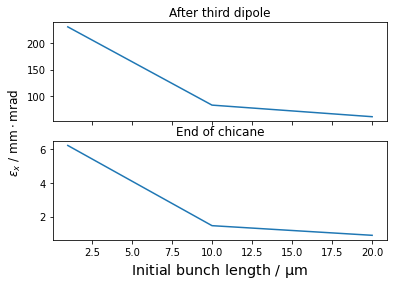

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(np.array(bunch_lengths)*1e6, np.array(emitxn_at_marker)*1e6) # Convert to mmmrad and µm.
ax2.plot(np.array(bunch_lengths)*1e6, np.array(emitxn_at_end)*1e6)
fig.supylabel(r"$\varepsilon_{x}\,\,/\,\,\mathrm{mm \cdot{} mrad}$")
ax1.set_title("After third dipole")
ax2.set_title("End of chicane")
ax2.set_xlabel(r"Initial bunch length / $\mathrm{\mu{}m}$")